In [1]:
import sys, os, time
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
from torch.utils.data import Dataset, DataLoader
import gym
import numpy as np
%matplotlib notebook
#%matplotlib tk
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import models
from foundation import util
from foundation import train

np.set_printoptions(linewidth=120)

In [2]:
parser = train.setup_standard_options(no_config=True)

args = parser.parse_args([])

args.no_test = True

args.device = 'cuda:0'
args.seed = 0

args.logdate = True
args.tblog = False
args.txtlog = False
args.saveroot = 'trained_nets'
args.save_freq = -1

args.dataset = 'svhn'
args.dataset = 'mnist'
# for emnist change link: 'http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip'
args.use_val = True
args.val_per = 1/6

args.num_workers = 4
args.batch_size = 128

args.start_epoch = 0
args.epochs = 10

args.name = 'test_on_mnist'

args.latent_dim = 3

now = time.strftime("%y-%m-%d-%H%M%S")
if args.logdate:
    args.name = os.path.join(args.name, now)
args.save_dir = os.path.join(args.saveroot, args.name)
print('Save dir: {}'.format(args.save_dir))

if args.tblog or args.txtlog:
    util.create_dir(args.save_dir)
    print('Logging in {}'.format(args.save_dir))
logger = util.Logger(args.save_dir, tensorboard=args.tblog, txt=args.txtlog)

# Set seed
if not hasattr(args, 'seed') or args.seed is None:
    args.seed = util.get_random_seed()
torch.manual_seed(args.seed)
np.random.seed(args.seed)
try:
    torch.cuda.manual_seed(args.seed)
except:
    pass

if not torch.cuda.is_available():
    args.device = 'cpu'
print('Using device {} - random seed set to {}'.format(args.device, args.seed))

Save dir: trained_nets/test_on_mnist/19-10-30-101933
Using device cuda:0 - random seed set to 0


In [3]:
datasets = train.load_data(args=args)
shuffles = [True, False, False]

loaders = [DataLoader(d, batch_size=args.batch_size, num_workers=args.num_workers) for d, s in zip(datasets, shuffles)]

trainloader, testloader = loaders[0], loaders[-1]
valloader = None if len(loaders) == 2 else loaders[1]

print('Input: {}, Output: {}'.format(args.din, args.dout))
print('traindata len={}, trainloader len={}'.format(len(datasets[0]), len(trainloader)))
if valloader is not None:
    print('valdata len={}, valloader len={}'.format(len(datasets[1]), len(valloader)))
print('testdata len={}, testloader len={}'.format(len(datasets[-1]), len(testloader)))
print('Batch size: {} samples'.format(args.batch_size))

Input: (1, 28, 28), Output: 10
traindata len=50000, trainloader len=391
valdata len=10000, valloader len=79
testdata len=10000, testloader len=79
Batch size: 128 samples


In [4]:
# Define Model
args.total_samples = {'train': 0, 'val':0, 'test': 0}
epoch = 0
best_loss = None
all_train_stats = []
all_val_stats = []
all_test_stats = []

args.din_flat = int(np.product(args.din))

class Simple(fd.Visualizable, fd.Trainable_Model):
    def __init__(self, net, table, beta=0, fix_norm=False):
        super().__init__(args.din, args.dout)
        self.criterion = nn.CosineSimilarity(dim=-1)
        self.net = net
        self.table = table
        self.table.weight.data.sub_(self.table.weight.data.mean(0,keepdim=True))
        
        self.fix_norm = fix_norm
        self.beta = beta
        if beta > 0:
            self.stats.new('reg')
        
        self.stats.new('confidence', 'accuracy')
        
    def forward(self, x):
        return self.net(x)
    
    def _visualize(self, info, logger=None):
        
        with torch.no_grad():
        
            D = self.criterion(self.table.weight.unsqueeze(1), info.pred.unsqueeze(0))
            
            iconf, pick = D.max(0)
            conf = 1./(iconf + 1e-4)
        
            confidence = conf.detach()
            correct = pick.sub(info.y).eq(0).float().detach()

        self.stats.update('confidence', confidence.mean())
        self.stats.update('accuracy', correct.mean())
        
        if 'reg' in info:
            self.stats.update('reg', info.reg.detach())
    
    def regularize(self):
        dists = F.pdist(self.table.weight)
        return -dists.log().mean()
        
#         return self.criterion(self.table.weight.unsqueeze(1), self.table.weight.unsqueeze(0)).mean()
    
    def _step(self, batch, out=None):
        if out is None:
            out = util.TensorDict()
            
        x,y = batch
        
        pred = self(x)
        
        cls = self.table(y)#.detach()
        
        loss = -self.criterion(pred, cls).mean()
        
        if self.beta > 0:
            reg = self.regularize()
            loss += self.beta * reg
            out.reg = reg
        
        if self.train_me():
            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            
        if self.fix_norm:
            with torch.no_grad():
                F.normalize(self.table.weight, p=2, dim=-1, out=self.table.weight)
            
        out.loss = loss
        out.x = x
        out.y = y
        out.pred = pred
        return out
    

net = nn.Sequential(nn.Flatten(), models.make_MLP(args.din_flat, args.latent_dim, hidden_dims=[300], nonlin='prelu'))
table = nn.Embedding(args.dout, args.latent_dim)

model = Simple(net, table, beta=1., fix_norm=True)
model.set_optim(optim_type='adam', lr=1e-3, weight_decay=1e-4, momentum=0.9)
scheduler = None#torch.optim.lr_scheduler.StepLR(optim, step_size=6, gamma=0.2)

model.to(args.device)
print(model)
print(model.optim)
print('Model has {} parameters'.format(util.count_parameters(model)))

Simple(
  (criterion): CosineSimilarity()
  (net): Sequential(
    (0): Flatten()
    (1): Sequential(
      (0): Linear(in_features=784, out_features=300, bias=True)
      (1): PReLU(num_parameters=1)
      (2): Linear(in_features=300, out_features=3, bias=True)
    )
  )
  (table): Embedding(10, 3)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.0001
)
Model has 236434 parameters


In [5]:
# Reseed after model init
torch.manual_seed(args.seed)
np.random.seed(args.seed)
try:
    torch.cuda.manual_seed(args.seed)
except:
    pass


if args.no_test:
    print('Will not run test data after training')
else:
    raise NotImplementedError

Will not run test data after training


In [ ]:
for _ in range(args.epochs):

    model.reset()

    train_stats = util.StatsMeter()
    train_stats.shallow_join(model.stats)

    train_stats = train.run_epoch(model, trainloader, args, mode='train',
                                  epoch=epoch, print_freq=args.print_freq, logger=logger, silent=True,
                                  viz_criterion_args=args.viz_criterion_args,
                                  stats=train_stats, )

    all_train_stats.append(train_stats.copy())

    if valloader is not None:
        model.reset()

        val_stats = util.StatsMeter()
        val_stats.shallow_join(model.stats)

        val_stats = train.run_epoch(model, valloader, args, mode='val',
                                  epoch=epoch, print_freq=args.print_freq, logger=logger, silent=True,
                                  viz_criterion_args=args.viz_criterion_args,
                                  stats=val_stats, )

        all_val_stats.append(val_stats.copy())

    print('[ {} ] Epoch {} Train={:.3f} ({:.3f}), Val={:.3f} ({:.3f})'.format(
        time.strftime("%H:%M:%S"), epoch+1,
        train_stats['accuracy'].avg.item(), train_stats['loss'].avg.item(),
        val_stats['accuracy'].avg.item(), val_stats['loss'].avg.item(),
    ))

    if args.save_freq > 0 and epoch % args.save_freq == 0:


        ckpt = {
            'epoch': epoch+1,

            'args': args,

            'model_str': str(model),
            'model_state': model.state_dict(),
            'all_train_stats': all_train_stats,
        }
        if args.track_best:
            av_loss = train_stats['loss'].avg.item() if valloader is None else val_stats['loss'].avg.item()
            is_best = best_loss is None or av_loss < best_loss
            if is_best:
                best_loss = av_loss
                best_epoch = epoch

            ckpt['loss'] = av_loss
            ckpt['best_loss'] = best_loss
            ckpt['best_epoch'] = best_epoch
        if len(all_val_stats):
            ckpt['all_val_stats'] = all_val_stats
        path = save_checkpoint(ckpt, args.save_dir, is_best=is_best, epoch=epoch+1)
        print('--- checkpoint saved to {} ---'.format(path))

    epoch += 1

[ 10:23:52 ] Epoch 41 Train=0.981 (-1.316), Val=0.981 (-1.318)
[ 10:23:53 ] Epoch 42 Train=0.980 (-1.315), Val=0.980 (-1.316)
[ 10:23:55 ] Epoch 43 Train=0.981 (-1.313), Val=0.981 (-1.315)
[ 10:23:57 ] Epoch 44 Train=0.982 (-1.311), Val=0.982 (-1.312)
[ 10:23:59 ] Epoch 45 Train=0.978 (-1.306), Val=0.978 (-1.309)
[ 10:24:01 ] Epoch 46 Train=0.986 (-1.313), Val=0.986 (-1.317)
[ 10:24:03 ] Epoch 47 Train=0.980 (-1.314), Val=0.980 (-1.317)
[ 10:24:04 ] Epoch 48 Train=0.984 (-1.317), Val=0.984 (-1.321)
[ 10:24:06 ] Epoch 49 Train=0.982 (-1.317), Val=0.982 (-1.316)


In [157]:
# stat_key = 'accuracy'

# figax = None
# figax = util.plot_stat(all_train_stats, key=stat_key, figax=figax, label='train')
# figax = util.plot_stat(all_val_stats, key=stat_key, figax=figax, label='val')
# fig, ax = figax
# plt.sca(ax)
# plt.xlabel('Epochs')
# plt.ylabel(stat_key)
# plt.legend()

In [21]:
batch = next(iter(trainloader))
x, y = util.to(batch, device=args.device)
x.shape, y.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [22]:
with torch.no_grad():
    pred = model(x)
    D = model.criterion(model.table.weight.unsqueeze(1), pred.unsqueeze(0)).t()
pred.shape, D.shape

(torch.Size([128, 3]), torch.Size([128, 10]))

In [23]:
with torch.no_grad():
    p = util.cart2angl(pred)
    c = util.cart2angl(model.table.weight)
    n = pred.norm(2,-1)
p.shape, c.shape, n.shape

(torch.Size([128, 2]), torch.Size([10, 2]), torch.Size([128]))

In [9]:
print('{:1.3f} +/- {:1.3f}   [{:1.3f}, {:1.3f}]'.format(n.mean().item(), n.std().item(), n.min().item(), n.max().item()))

0.120 +/- 0.055   [0.026, 0.286]


<IPython.core.display.Javascript object>


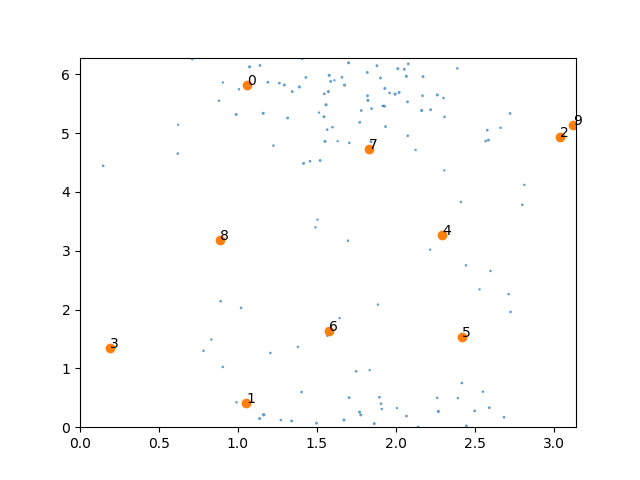

(0, 6.283185307179586)

In [10]:
fig = plt.figure()
cls = c.cpu().numpy()
pts = p.cpu().numpy()
plt.scatter(*pts.T, marker='.', s=n.cpu().numpy()*50+10, edgecolors='none', alpha=.7)
plt.scatter(*cls.T)
for i in range(cls.shape[0]):
    plt.annotate(str(i), cls[i])
plt.xlim([0,np.pi])
plt.ylim([0,2*np.pi])

In [27]:
print('{:1.3f} +/- {:1.3f}   [{:1.3f}, {:1.3f}]'.format(n.mean().item(), n.std().item(), n.min().item(), n.max().item()))

1.184 +/- 0.744   [0.082, 3.306]


<IPython.core.display.Javascript object>


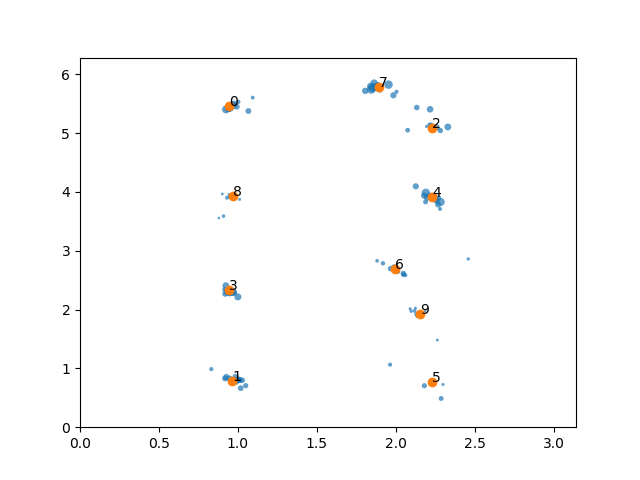

(0, 6.283185307179586)

In [28]:
fig = plt.figure()
cls = c.cpu().numpy()
pts = p.cpu().numpy()
plt.scatter(*pts.T, marker='.', s=n.cpu().numpy()*50+10, edgecolors='none', alpha=.7)
plt.scatter(*cls.T)
for i in range(cls.shape[0]):
    plt.annotate(str(i), cls[i])
plt.xlim([0,np.pi])
plt.ylim([0,2*np.pi])

In [18]:
print('{:1.3f} +/- {:1.3f}   [{:1.3f}, {:1.3f}]'.format(n.mean().item(), n.std().item(), n.min().item(), n.max().item()))

0.739 +/- 0.462   [0.064, 2.289]


<IPython.core.display.Javascript object>


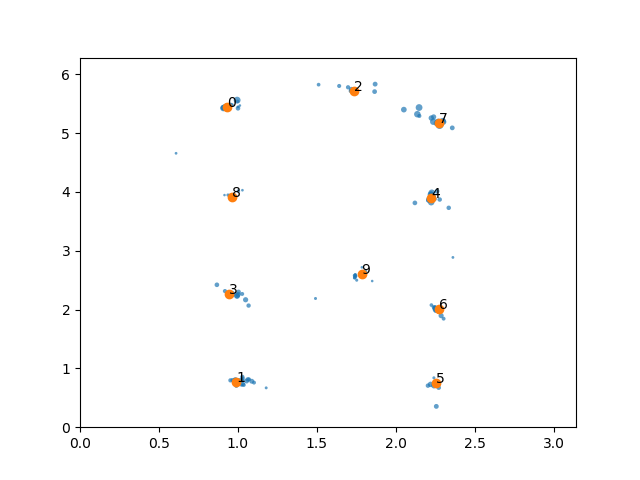

(0, 6.283185307179586)

In [19]:
fig = plt.figure()
cls = c.cpu().numpy()
pts = p.cpu().numpy()
plt.scatter(*pts.T, marker='.', s=n.cpu().numpy()*50+10, edgecolors='none', alpha=.7)
plt.scatter(*cls.T)
for i in range(cls.shape[0]):
    plt.annotate(str(i), cls[i])
plt.xlim([0,np.pi])
plt.ylim([0,2*np.pi])

In [49]:
D[:4]

tensor([[ 0.9976,  0.9796,  0.9929,  0.9953, -0.9626,  0.9982,  0.2457,  0.5397,
          0.9738, -0.0836],
        [ 0.9870,  0.9939,  0.9778,  1.0000, -0.9335,  0.9885,  0.1554,  0.6150,
          0.9906,  0.0085],
        [-0.5530, -0.3093, -0.5940, -0.4081,  0.7113, -0.5453, -0.9641,  0.4651,
         -0.2838,  0.9076],
        [ 0.9747,  0.9989,  0.9623,  0.9982, -0.9087,  0.9767,  0.0918,  0.6642,
          0.9973,  0.0725]], device='cuda:0')